# Проверка гипотез по увеличению выручки в интернет-магазине — оценка результатов A/B теста

**Запрос на исследование:**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

**Задачи исследования**

`1. Приоритизация гипотез`
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

`2. Анализ A/B-теста`
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

Проанализировать A/B-тест:
- Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
- Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
- Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.
- Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.
- Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Построить точечный график стоимостей заказов. Сделать выводы и предположения.
- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
- Принять решение по результатам теста и объяснить его. 
    Варианты решений:
    1. Остановить тест, зафиксировать победу одной из групп. 
    2. Остановить тест, зафиксировать отсутствие различий между группами. 
    3. Продолжить тест.

## Описание данных

**Данные для приоретизации гипотез**

Файл /datasets/hypothesis.csv

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные A/B-теста** 

Файл /datasets/orders.csv

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка и предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
from scipy import stats as st
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import GridspecLayout
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

# устанавливаем формат отображения таблицы и данных
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 150
sns.set_style('darkgrid')

In [2]:
# загрузка данных
hypothesis = pd.read_csv('/datasets/hypothesis.csv') #список гипотез
orders = pd.read_csv('/datasets/orders.csv') # журнал покупок
visitors = pd.read_csv('/datasets/visitors.csv') # журнал сессий 

In [3]:
# чтение данных и вывод информации о таблицах
tables = [hypothesis, orders, visitors]

for table in tables:
    display(table.head())
    temp_table = table.copy() 
    list_c = table.columns
    print(temp_table.info())
    print('-------------------------')
    print('кол-во дубликатов:',temp_table.duplicated().sum())
    for col_l in list_c:
        print('-------------------------')
        print(col_l, temp_table[col_l].sort_values().unique())
        print('уникальных значений:', len(temp_table[col_l].unique()))
        print(col_l,': кол-во NaN',temp_table[col_l].isna().sum(),
        ', процент NaN', round(temp_table[col_l].isna().sum()/len(temp_table)*100, 2),'%')

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
-------------------------
кол-во дубликатов: 0
-------------------------
Hypothesis ['Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'
 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'
 'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов'
 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'
 'Запустить акцию, дающую скидку на товар в день рождения'
 'Запустить

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
-------------------------
кол-во дубликатов: 0
-------------------------
transactionId [   1062393    4919758    7210578 ... 4281129020 4288552432 4293855558]
уникальных значений: 1197
transactionId : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
visitorId [   5114589    6958315    8300375 ... 4279090005 4281247801 4283872382]
уникальных значений: 1031
visitorId : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
date ['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' 

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
-------------------------
кол-во дубликатов: 0
-------------------------
date ['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09' '2019-08-10'
 '2019-08-11' '2019-08-12' '2019-08-13' '2019-08-14' '2019-08-15'
 '2019-08-16' '2019-08-17' '2019-08-18' '2019-08-19' '2019-08-20'
 '2019-08-21' '2019-08-22' '2019-08-23' '2019-08-24' '2019-08-25'
 '2019-08-26' '2019-08-27' '2019-08-28' '2019-08-29' '2019-08-30'
 '2019-08-31']
уникальных значений: 31
date : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
group ['A' 'B']
уникальных значений: 2
group : кол-во NaN 0 , процент NaN 

**Результаты ознакомления с данными**

При первичном ознакомлении проблемных данных не обнаружено.

**Произведем предобработку данных**
- Приведем наименования столбцов к стилю snake_case;
- Переименуем столбцы в таблице orders - `transactionId:orderID`, `visitorId:userId`;
- Преобразуем значения даты в таблицах методом `strptime`

In [4]:
# приведение наименований столбцов к общепринятому стилю
hypothesis.columns = hypothesis.columns.str.lower()

# переименовывание столбцов
orders = orders.rename(columns={'transactionId':'orderId', 'visitorId':'userId'})

# преобразование даты
ab_tables = [orders,visitors]

for table in ab_tables:
    table['date'] = table['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

**Результаты предобработки данных**

Были внесены все необходимые корректировки. Данные готовы к дальнейшей работе.

## Приоретизация гипотез

Приоретизацию гипотез будем производить используя базовую таблицу `hypothesis`. Ознакомимся с полным содержанием таблицы.

In [5]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Структура таблицы, говорит о том, что для ее построения использовался фреймворк RICE. Произведем расчеты и выясним силу гипотез, приоретизировав их.

Сперва приоретизируем гипотезы с использованием фреймворка ICE, после чего используем фреймворк RICE.

In [6]:
#приоретизация гипотез с использованием фреймворка 'ICE'
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

#приоретизация гипотез с использованием фреймворка 'RICE'
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

display(hypothesis[['hypothesis','ICE', 'RICE']].sort_values(['RICE', 'ICE'],ascending=[False, False]))

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200,16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125,9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000,4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333,4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000,3.000


В ходе приоритезации гипотез методом `ICE` было установлено, что наибольшей силой обладают гипотезы номер: 8, 0, 7. Однако, при учете не только силы но и охвата пользователей которых затронет гипотеза, использовав фреймворк `RICE` в числе приорететных оказались гипотезы: 7, 2 , 0.

Бесспорным лидером по силе и охвату оказалась гипотеза номер `7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`

## Анализ A/B-теста

Проведем анализ A/B-теста. Начнем с определения количества наблюдений по каждой из групп, на основе которых будем проводить A/B-тест.

In [7]:
size_group=orders['group'].value_counts().to_frame()
display(size_group)

difference = (1-size_group['group'].min()/size_group['group'].max())*100
print('Относительное различие количества наблюдений по группам:', difference.round(2),'%')

,group
B,640
A,557


Относительное различие количества наблюдений по группам: 12.97 %


Наблюдений в группе B болше чем в группы A почти на 13%. Стоит учесть данный факт при проведении A/B-теста, т.к. могут исказиться результаты теста.

Проверим группы на вероятность вхождения одного пользователя в две группы одновременно.

In [8]:
orders_raw = orders.copy()

orders_raw = orders_raw.groupby(['userId', 'group', 'date']).agg({'orderId': 'nunique', 'revenue': 'sum'}).reset_index()
orders_raw = orders_raw[orders_raw.groupby('userId').userId.transform('count') > 1].reset_index(drop=True)

display(orders_raw.head(10))
print('Количество пользователей, попавших в группы A и B:', orders_raw['userId'].nunique())
print('Количество строк с данными:', len(orders_raw))
print('Доля:', round((len(orders_raw)/len(orders)*100),2), '%')


,userId,group,date,orderId,revenue
0,8300375,A,2019-08-07,1,1790
1,8300375,B,2019-08-01,1,10510
2,199603092,A,2019-08-12,1,6438
3,199603092,A,2019-08-15,1,3488
4,199603092,A,2019-08-22,1,6976
5,199603092,A,2019-08-27,1,2790
6,199603092,B,2019-08-02,1,3488
7,232979603,A,2019-08-31,1,60
8,232979603,B,2019-08-31,1,2640
9,237748145,A,2019-08-12,1,340


Количество пользователей, попавших в группы A и B: 83
Количество строк с данными: 223
Доля: 18.63 %


Удалось найти 83 пользователя которые за время наблюдений оказались в двух группах. Вероятней всего группы формировались по проходящим транзакциям, которым присваивалась категория A или B.

Фильтровать эти данные без надобности - иначе потеряем ценную информацию и большой объем данных.

Наблюдений в группе B болше чем в группы A почти на 13%. Стоит учесть данный факт при проведении A/B-теста, т.к. могут исказиться результаты теста.

Проверим, можно ли считать ключевые переменные нормально распределенными:
- количество ежедневных посещений;
- количество заказов в день;
- ежедневная выручка.

Для проверки данных на нормальность применим критерий Шапиро-Уилка. Также, произведем расчет длительности эксперимента.

Сформулируем нулевую и альтернативную гипотезы:

`Нулевая гипотеза:` переменные: количество ежедневных посещений, количество заказов в день, ежедневная выручка, - распределены нормально;

`Альтернативная гипотеза:` переменные: количество ежедневных посещений, количество заказов в день, ежедневная выручка, - распределены не нормально.

In [9]:
# таблица 'ежедневная выручка'
daily_revenue = orders.groupby('date')['revenue'].sum().to_frame().reset_index()

# таблица 'количество заказов в день'
daily_order = orders.groupby('date')['orderId'].count().to_frame().reset_index()

# таблица 'количество ежедневных посещений'
daily_visitors = visitors.groupby('date')['visitors'].sum().to_frame().reset_index()

# сводная таблица
variables = daily_revenue.merge(daily_order, on='date').merge(daily_visitors, on='date')
variables = variables.rename(columns={'orderId':'orders', 'visitors':'visits'})

print('Длительность наблюдений:', len(variables),'день')

# проверка данных на нормальность распределения
for values in [variables['revenue'],variables['orders'],variables['visits']]:
    alpha = 0.05  # критический уровень статистической значимости
    
    results = st.shapiro(values)
    p_value = results[
        1
    ]  # второе значение в массиве результатов (с индексом 1) - p-value
    
    print('-------------------------')
    print(values.name)
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

Длительность наблюдений: 31 день
-------------------------
revenue
p-значение:  5.318755658123564e-09
Отвергаем нулевую гипотезу: распределение не нормально
-------------------------
orders
p-значение:  0.015063215978443623
Отвергаем нулевую гипотезу: распределение не нормально
-------------------------
visits
p-значение:  0.02096445858478546
Отвергаем нулевую гипотезу: распределение не нормально


Эксперимент длился 31 день.

По итогам проведения параметрического теста Шапиро-Уилка на проверку нормальности распределения накопленных данных принимаем альтернативную гипотезу. Ключевые переменные распределены не нормально, что говорит о подверженности переменных выбросам. Учтем этот факт при анализе A/B-теста.

### Изучение кумулятивных метрик

Для того чтобы исключить проблему подсматривания, проанализируем графики метрик.

Прежде чем перейти к построению графиков, создадим таблицу накопляемых данных по группам в ходе эксперимента.

In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'orderId': 'nunique',
            'userId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeA = cumulativeData[cumulativeData['group']=='A'][
    ['date','revenue', 'orders', 'conversion']
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeB = cumulativeData[cumulativeData['group']=='B'][
    ['date','revenue', 'orders', 'conversion']
]

# собираем данные в одном датафрейме
cumulative_df = cumulativeA.merge(cumulativeB,
                                     left_on='date', 
                                     right_on='date', 
                                     how='left', 
                                     suffixes=['A', 'B'])


cumulative_df.head()

,date,revenueA,ordersA,conversionA,revenueB,ordersB,conversionB
0,2019-08-01,148579,24,0.033,101217,21,0.029
1,2019-08-02,242401,44,0.033,266748,45,0.035
2,2019-08-03,354874,68,0.037,380996,61,0.034
3,2019-08-04,425699,84,0.033,489567,78,0.030
4,2019-08-05,549917,109,0.033,581995,101,0.031


**Графики кумулятивных метрик**

Изучим графики кумулятивных данных. Таким образом отследим изменения результатов эксперимента на каждый день тестирования.
- Построим график кумулятивной выручки по группам и проанализируем его;
- Построим график кумулятивного среднего чека по группам и проанализируем его;
- Построим график относительного изменения кумулятивного среднего чека группы B к группе A;
- Построим график кумулятивной конверсии по группам и проанализируем его;
- Построим график относительного изменения кумулятивной конверсии группы B к группе A;

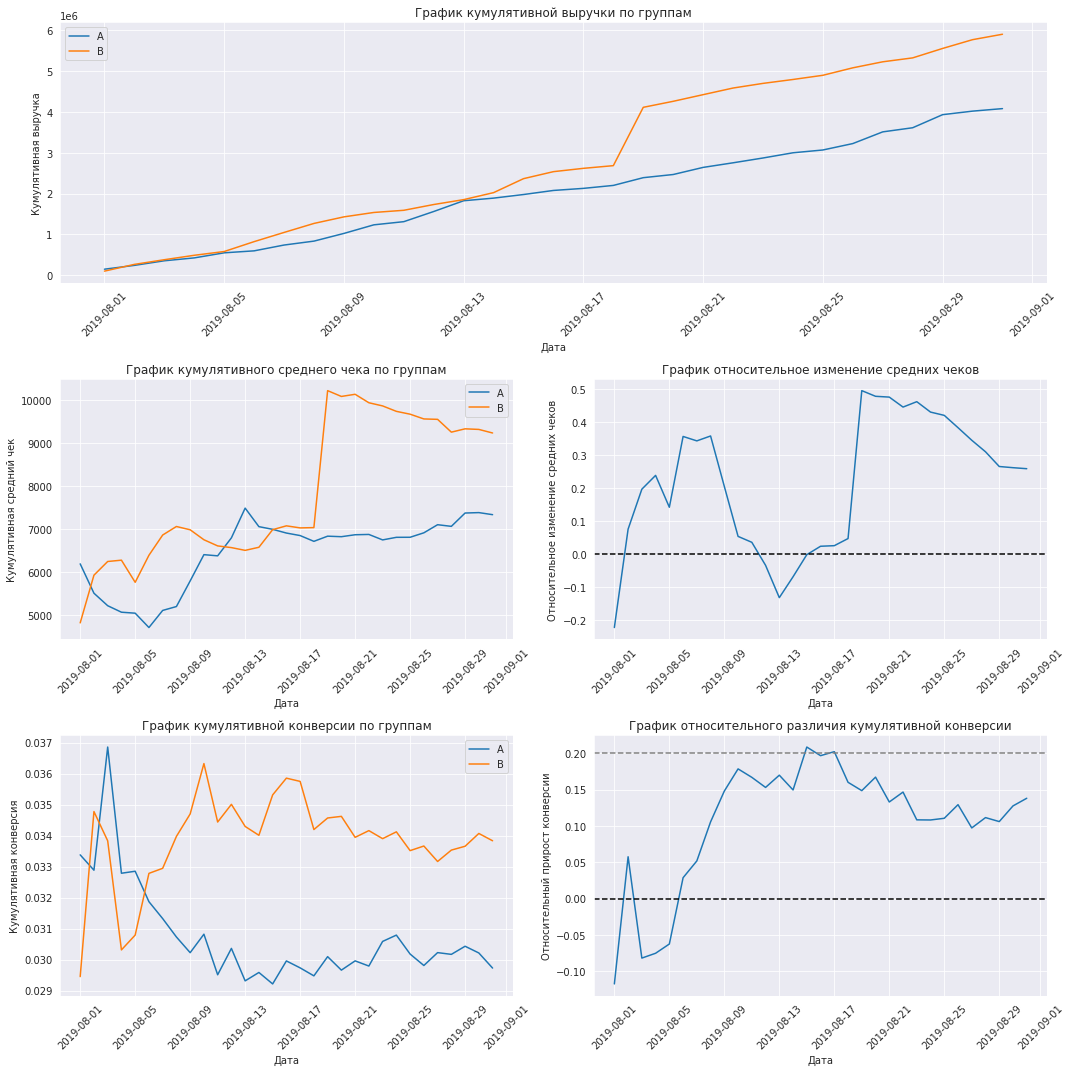

In [11]:
plt.figure(figsize=(15,15))

# график кумулятивной выручки по группам
plt.subplot (3, 1, 1)
plt.plot(cumulativeA['date'], cumulativeA['revenue'], label='A')
plt.plot(cumulativeB['date'], cumulativeB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.xticks(rotation=45)
plt.legend()

# график кумулятивного среднего чека
plt.subplot (3, 2, 3)
plt.plot(cumulativeA['date'], cumulativeA['revenue']/cumulativeA['orders'], label='A')
plt.plot(cumulativeB['date'], cumulativeB['revenue']/cumulativeB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная средний чек')
plt.xticks(rotation=45)
plt.legend()

# график отношения кумулятивных средних чеков
plt.subplot (3, 2, 4)
plt.plot(cumulative_df['date'], 
         (cumulative_df['revenueB']/cumulative_df['ordersB'])/(cumulative_df['revenueA']/cumulative_df['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительное изменение средних чеков')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение средних чеков')
plt.xticks(rotation=45)

# график кумулятивной конверсии
plt.subplot (3, 2, 5)
plt.plot(cumulativeA['date'], cumulativeA['conversion'], label='A')
plt.plot(cumulativeB['date'], cumulativeB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.xticks(rotation=45)
plt.legend()

# график относительного различия кумулятивной конверсии
plt.subplot (3, 2, 6)
plt.plot(cumulative_df['date'], 
         cumulative_df['conversionB']/cumulative_df['conversionA']-1)
plt.title('График относительного различия кумулятивной конверсии')
plt.xlabel('Дата')
plt.ylabel('Относительный прирост конверсии')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.tight_layout()
plt.show()

И так, судя по графикам можно сделать следующие выводы:
- Кумулятивная выручка группы B была на одном уровне с группой A примерно до 18 августа 2019 года. Начиная с этой даты на графике наблюдается всплеск кумулятивной выручки в группе B. Установленная разница кумулятивной выручки сохранилась до конца наблюдений.
- Аналогичная ситуация наблюдается и на графике кумулятивного среднего чека - начиная с 18.08.2019 наблюдается резкое увеличение среднего чека по группе B. Вероятно, в этот период были совершены очень дорогие покупки. На данный момент в группе наблюдается снижение величины среднего чека относительно пикового значения - более 10000. В группе A средний чек на конец наблюдений находится около 7,5 тысяч, в группе B - 9,3 тысяч
- График относительного изменения величины среднего чека не стабилен. Отмечаются резкие всплески и падения на протяжении всего периода наблюдения. Вероятно, резкие подъемы обусловлены наличием аномально высоких по стоимости заказов.
- Конверсия группы A - 30% ниже чем конверсия группы B - 34%
- График относительного изменения конверсии резко менялся в первых числах месяца. Вероятно, это обусловлено поступлением новых данных. Затем группа В начала стабильно опережать группу А, прирост зафиксировался на уровне 15%

### Анализ выбросов и всплесков

Решим вопрос с аномалиями и выбросами, влияние которых было обнаружено в ходе проведения параметрического теста Шапиро-Уилка при проверки нормальности распределения данных, и отразившихся на графиках кумулятивных данных.

В ходе анализа:
- Построим точечный график количества заказов по пользователям и проанализируем его;
- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.
- Построим точечный график стоимостей заказов.
- Посчитаем 95-й и 99-й перцентили стоимости заказов. Определим границу для определения аномальных заказов.

Начнем с подсчета количества заказов по пользователям и построения точечной диаграммы по полученным данным. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [12]:
out_box1 = widgets.Output(layout={"border":"1px"})
out_box2 = widgets.Output(layout={"border":"1px"})

with out_box1:
    ordersByUsers = (
        orders.groupby('userId', as_index=False)
        .agg({'orderId': 'nunique'})
    )
    ordersByUsers.columns = ['userId', 'orders']
        
    print('Количество заказов на одного пользователя')
    display(ordersByUsers.sort_values(by='orders', ascending=False).head(7))
    print('95-й перцентель количества заказов:',(np.percentile(ordersByUsers['orders'], 95)).astype(int))
    print('99-й перцентель количества заказов:',(np.percentile(ordersByUsers['orders'], 99)).astype(int))  
    
with out_box2:
    x_values = pd.Series(range(0,len(ordersByUsers)))
    plt.scatter(x_values, ordersByUsers['orders']) 
    plt.tight_layout()
    plt.title('Диаграмма распределения числа заказов на одного пользователя')
    plt.xlabel('Количество уникальных пользователей')
    plt.ylabel('Количество заказов на одного пользователя')
    plt.show()

grid = GridspecLayout(10, 3)
grid[:, 0] = out_box1
grid[:, 1:4] = out_box2

grid

GridspecLayout(children=(Output(layout=Layout(border='1px', grid_area='widget001')), Output(layout=Layout(bord…

Только 5% из всех пользоватлей совершает более двух заказов и только 1% пользователей совершает более 4 заказов. В качестве верхней границы по количеству заказов установим значение равное 95-му перцентелю - 2 заказа.


Повторим процедуру для стоимости заказов: построим точечный график стоимостей заказов, посчитаем 95-й и 99-й перцентили стоимости заказов. Определим границу для определения аномальных заказов.

In [13]:
out_box3 = widgets.Output(layout={"border":"1px"})
out_box4 = widgets.Output(layout={"border":"1px"})

with out_box3:
    revenue = orders['revenue'].to_frame() 
    print('Выручка с заказов')
    display(revenue.sort_values(by='revenue', ascending=False).head(7))
    print('95-й перцентель выручки с заказов:',(np.percentile(revenue['revenue'], 95)).astype(int))
    print('99-й перцентель выручки с заказов:',(np.percentile(revenue['revenue'], 99)).astype(int)) 
    
with out_box4:
    x_values = pd.Series(range(0,len(revenue)))
    sns.scatterplot(x=x_values, y='revenue', data=orders, hue='group') 
    plt.tight_layout()
    plt.title('Диаграмма распределения выручек с заказов по пользователямя')
    plt.xlabel('Количество пользователей')
    plt.ylabel('Стоимость заказов')
    plt.show()

grid = GridspecLayout(10, 3)
grid[:, 0] = out_box3
grid[:, 1:4] = out_box4

grid

GridspecLayout(children=(Output(layout=Layout(border='1px', grid_area='widget001')), Output(layout=Layout(bord…

По группе B найдены два аномальных по стоимости заказа на 1294500 и 202740. Исключим их из набора данных для корректного построения диаграммы. Повторим код.

In [14]:
out_box3 = widgets.Output(layout={"border":"1px"})
out_box4 = widgets.Output(layout={"border":"1px"})

with out_box3:
    orders_new = orders.copy()
    orders_new = orders_new.query('revenue < 200000')
    print('Выручка с заказов')
    display(revenue.sort_values(by='revenue', ascending=False).head(7))
    print('95-й перцентель выручки с заказов:',(np.percentile(revenue['revenue'], 95)).astype(int))
    print('99-й перцентель выручки с заказов:',(np.percentile(revenue['revenue'], 99)).astype(int)) 
    
with out_box4:
    x_values = pd.Series(range(0,len(orders_new)))
    sns.scatterplot(x=x_values, y='revenue', data=orders_new, hue='group')
    plt.tight_layout()
    plt.title('Диаграмма распределения выручек с заказов по пользователямя')
    plt.xlabel('Количество пользователей')
    plt.ylabel('Стоимость заказов')
    plt.show()

grid = GridspecLayout(10, 3)
grid[:, 0] = out_box3
grid[:, 1:4] = out_box4

grid

GridspecLayout(children=(Output(layout=Layout(border='1px', grid_area='widget001')), Output(layout=Layout(bord…

Судя по диаграмме, наибольшее число пользователей совершает заказы стоимостью до 20 тысяч. Согласно произведенным расчетам только 5% пользователей совершают единоразовые покупки на сумму более 28000 и только 1% выше 58233.
Определим верхнюю границу на стоимость заказа в соответсвии со значением 95-го перцентеля - 28000.

### Подсчет статистической значимости различий

В ходе проведения теста посчитаем статистическую значимость различий
- В среднем чеке заказа между группами по «сырым» и «очищенным» данным;
- В конверсии между группами по «сырым» и «очищенным» данным; 

Сформулируем гипотезы:

**Средний чек**

`Нулевая гипотеза:` различий в среднем чеке между группами нет;

`Альтернативная гипотеза:` различия в среднем чеке между группами есть.

**Конверсия**

`Нулевая гипотеза:` различий в конверсии между группами нет;

`Альтернативная гипотеза:`различия в конверсии между группами есть.

**`Критический уровень статистической значимости - 0.05`**

Для подсчета статистической значимости различий воспользуемся критерием Манна-Уитни. Подготовим данные для проведения теста.

In [15]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ), axis=1,)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ), axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ), axis=1,).sort_values(by=['date'])
ordersACummulative.columns = ['date','ordersCummulativeA','revenueCummulativeA',]
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ), axis=1,).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB',]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'], pd.Series(0, index=np.arange(
            data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
        ),name='orders',),
    ], axis=0,
)
sampleB = pd.concat(
    [
        ordersByUsersB['orders'], pd.Series(0, index=np.arange(
            data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
        ), name='orders', ),], axis=0,
)

Применим критерий Манна-Уитни и произведем расчеты, используя набор сырых данных.

In [16]:
def mannwhitneyutestraw(head, value, text):
    alpha = 0.05
    
    if value == 'revenue':
        p_value = st.mannwhitneyu(orders[orders['group']=='A'][value], orders[orders['group']=='B'][value])[1]
        difference = orders[orders['group']=='B'][value].mean()/orders[orders['group']=='A'][value].mean()-1
    elif value == 'conversion':
        p_value = st.mannwhitneyu(sampleA, sampleB)[1]
        difference = sampleB.mean() / sampleA.mean() - 1
    

    print('-------------------------')
    print(head, value)
    print('p-значение: ', '{0:.3f}'.format(p_value))
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: различия в', text, 'между группами есть')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: различий в', text, 'между группами нет')
    print('Прирост среднего группы B по отношению к группе A: ', '{0:.3f}'.format(difference*100),'%')

mannwhitneyutestraw('Сырые данные', 'revenue', 'среднем чеке')
mannwhitneyutestraw('Сырые данные', 'conversion', 'конверсии')

-------------------------
Сырые данные revenue
p-значение:  0.729
Не получилось отвергнуть нулевую гипотезу: различий в среднем чеке между группами нет
Прирост среднего группы B по отношению к группе A:  25.871 %
-------------------------
Сырые данные conversion
p-значение:  0.017
Отвергаем нулевую гипотезу: различия в конверсии между группами есть
Прирост среднего группы B по отношению к группе A:  13.808 %


По итогам проверки гипотез по сырым данным установлено:
- Нулевую гипотезу о том, что различий в среднем чеке между группами нет, отвергнуть не удалось. Значение p-value выше уровня статистической значимости;
- По среднему чеку наблюдается прирост в группе B по отношению к группе A в 25.8%;
- Гипотеза о том, что нет разницы в конверсиях групп, опровергнута в пользу альтернативной - различия в конверсии между группами есть;
- Прирост конверсии группы B по отношению к группе A составляет 13.8%.

Очистим данные от аномалий и произведем повторный расчет. 

Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [17]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
     ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId']],axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(revenue['revenue'], 95)]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [18]:
def mannwhitneyutestclean(head, value, text):
    alpha = 0.05
    
    if value == 'revenue':
        p_value = st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['userId'].isin(abnormalUsers)),)][value], orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['userId'].isin(abnormalUsers)),)][value],)[1]    
        difference = orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['userId'].isin(abnormalUsers)),)][value].mean()/orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['userId'].isin(abnormalUsers)),)][value].mean()- 1

    elif value == 'conversion':
        p_value = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
        difference = sampleBFiltered.mean() / sampleAFiltered.mean() - 1
    
    print('-------------------------')
    print(head, value)
    print('p-значение: ', '{0:.3f}'.format(p_value))
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: различия в', text, 'между группами есть')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: различий в', text, 'между группами нет')
    print('Прирост среднего группы B по отношению к группе A: ', '{0:.3f}'.format(difference*100),'%')
    
mannwhitneyutestclean('Чистые данные', 'revenue', 'среднем чеке')
mannwhitneyutestclean('Чистые данные', 'conversion', 'конверсии')


-------------------------
Чистые данные revenue
p-значение:  0.738
Не получилось отвергнуть нулевую гипотезу: различий в среднем чеке между группами нет
Прирост среднего группы B по отношению к группе A:  -1.962 %
-------------------------
Чистые данные conversion
p-значение:  0.013
Отвергаем нулевую гипотезу: различия в конверсии между группами есть
Прирост среднего группы B по отношению к группе A:  17.270 %


По результатам применения критерия Манна-Уитни к чистым выборкам известно:
- Нулевую гипотезу о том, что различий в среднем чеке между группами нет, отвергнуть не получилось. Отличий не наблюдается. Полученное значение p-value выше уровня статистической значимости;
- Прирост величины среднего чека наблюдается в группе A по сравнению с группой B на 1.96%;
- Наблюдаются различия в конверсиях групп. Нулевая гипотеза отвергается
- Прирост конверсии группы B по отношению к группе A 17.27%.

Сравним результаты двух проверок и определим качественные изменения.

In [19]:
out_box5 = widgets.Output(layout={"border":"1px"})
out_box6 = widgets.Output(layout={"border":"1px"})

with out_box5:
     
    mannwhitneyutestraw('Сырые данные', 'revenue', 'среднем чеке')
    mannwhitneyutestraw('Сырые данные', 'conversion', 'конверсии')
    
with out_box6:
    
    mannwhitneyutestclean('Чистые данные', 'revenue', 'среднем чеке')
    mannwhitneyutestclean('Чистые данные', 'conversion', 'конверсии')
    
grid = GridspecLayout(10, 2)
grid[:, 0] = out_box5
grid[:, 1:4] = out_box6

grid

GridspecLayout(children=(Output(layout=Layout(border='1px', grid_area='widget001')), Output(layout=Layout(bord…

По итогу проведения проверок установлено:
- Нулевую гипотезу о том, что различий в среднем чеке между группами нет, не отвергаем. Разница p-value по сырым и чистым данным составляет 0.009. Различий в среднем чеке между группами A и B нет.
- Прирост среднего чека по группе B изменился в пользу группы A на 27.83%. Большое влияние на изменения велчины прироста оказали пользователи группы B совершившие очень дорогие покупки. По чистым данным группа A опережает группу B по приросту величины среднего чека на 1.96%.
- Наблюдаются различия в конверсии. Значение p-value по сырым и чистым данным ниже уровня статистической значимости. Отвергаем нулевую гипотезу: различия в конверсии между группами есть.
- Группа B конвертируется лучше группы A. Прирост конверсии в группе B по отношению к A, в результате проведения проверки по очищенному набору данных увеличился 3.46% и составляет 17.27%.

### Сравнительный анализ кумулятивных метрик

Проведем сравнительный анализ кумулятивных метрик по сырому и чистому набору данных.

Создадим таблицу с фильтрованными значениями в соответсвии с установленными параметрами верхних границ.

In [20]:
# создаем массив уникальных пар значений дат и групп теста
ordersFiltered = orders[np.logical_not(orders['userId'].isin(abnormalUsers))]
datesGroupsFiltered = ordersFiltered[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregatedFiltered = datesGroupsFiltered.apply(
    lambda x: ordersFiltered[
        np.logical_and(
            ordersFiltered['date'] <= x['date'], ordersFiltered['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'orderId': 'nunique',
            'userId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях
visitorsAggregatedFiltered = datesGroupsFiltered.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeDataFiltered = ordersAggregatedFiltered.merge(
    visitorsAggregatedFiltered, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeDataFiltered.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# считаем кумулятивную конверсию
cumulativeDataFiltered['conversion'] = cumulativeDataFiltered['orders']/cumulativeDataFiltered['visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeAFiltered = cumulativeDataFiltered[cumulativeDataFiltered['group']=='A'][
    ['date','revenue', 'orders', 'conversion']
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeBFiltered = cumulativeDataFiltered[cumulativeDataFiltered['group']=='B'][
    ['date','revenue', 'orders', 'conversion']
]

# собираем данные в одном датафрейме
cumulative_dfFiltered = cumulativeAFiltered.merge(cumulativeBFiltered,
                                     left_on='date', 
                                     right_on='date', 
                                     how='left', 
                                     suffixes=['A', 'B'])

Построим попарно графики кумулятивных метрик по двум наборам данных.

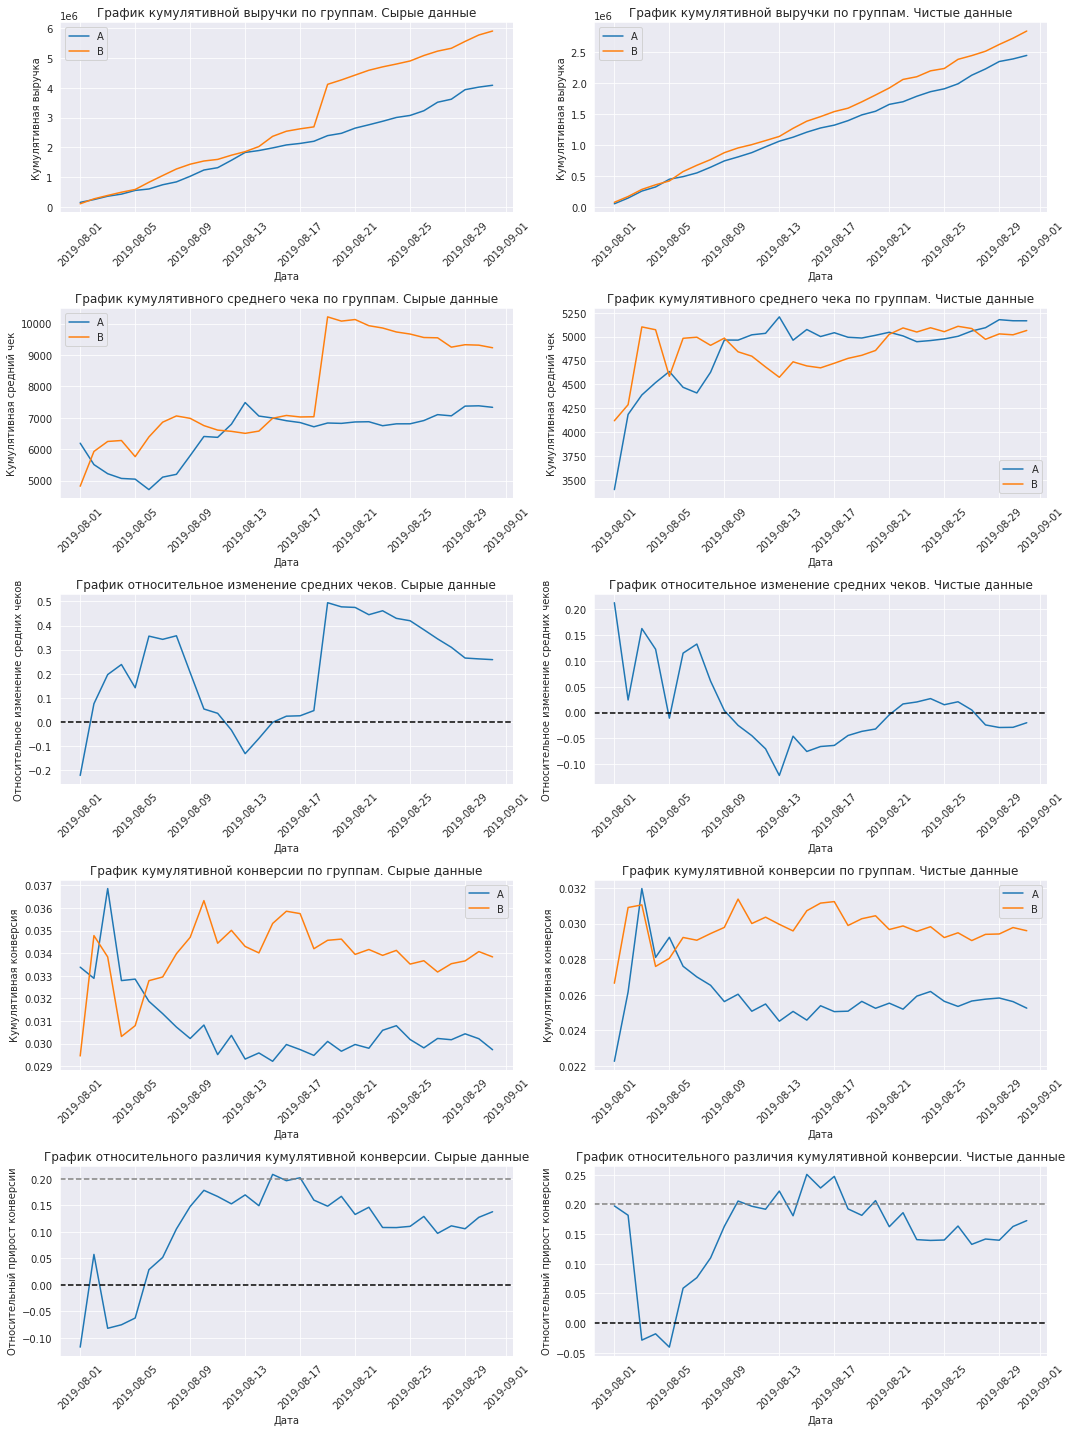

In [21]:
plt.figure(figsize=(15,20))

# график кумулятивной выручки по группам
# cырые данные
plt.subplot (5, 2, 1)
plt.plot(cumulativeA['date'], cumulativeA['revenue'], label='A')
plt.plot(cumulativeB['date'], cumulativeB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам. Сырые данные')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.xticks(rotation=45)
plt.legend()

# график кумулятивной выручки по группам
# чистые данные
plt.subplot (5, 2, 2)
plt.plot(cumulativeAFiltered['date'], cumulativeAFiltered['revenue'], label='A')
plt.plot(cumulativeBFiltered['date'], cumulativeBFiltered['revenue'], label='B')
plt.title('График кумулятивной выручки по группам. Чистые данные')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.xticks(rotation=45)
plt.legend()

# график кумулятивного среднего чека
# cырые данные
plt.subplot (5, 2, 3)
plt.plot(cumulativeA['date'], cumulativeA['revenue']/cumulativeA['orders'], label='A')
plt.plot(cumulativeB['date'], cumulativeB['revenue']/cumulativeB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам. Сырые данные')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная средний чек')
plt.xticks(rotation=45)
plt.legend()

# график кумулятивного среднего чека
# чистые данные
plt.subplot (5, 2, 4)
plt.plot(cumulativeAFiltered['date'], cumulativeAFiltered['revenue']/cumulativeAFiltered['orders'], label='A')
plt.plot(cumulativeBFiltered['date'], cumulativeBFiltered['revenue']/cumulativeBFiltered['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам. Чистые данные')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная средний чек')
plt.xticks(rotation=45)
plt.legend()

# график отношения кумулятивных средних чеков
# cырые данные
plt.subplot (5, 2, 5)
plt.plot(cumulative_df['date'], 
         (cumulative_df['revenueB']/cumulative_df['ordersB'])/(cumulative_df['revenueA']/cumulative_df['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительное изменение средних чеков. Сырые данные')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение средних чеков')
plt.xticks(rotation=45)

# график отношения кумулятивных средних чеков
# чистые данные
plt.subplot (5, 2, 6)
plt.plot(cumulative_dfFiltered['date'], 
         (cumulative_dfFiltered['revenueB']/cumulative_dfFiltered['ordersB'])/(cumulative_dfFiltered['revenueA']/cumulative_dfFiltered['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительное изменение средних чеков. Чистые данные')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение средних чеков')
plt.xticks(rotation=45)

# график кумулятивной конверсии
# cырые данные
plt.subplot (5, 2, 7)
plt.plot(cumulativeA['date'], cumulativeA['conversion'], label='A')
plt.plot(cumulativeB['date'], cumulativeB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам. Сырые данные')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.xticks(rotation=45)
plt.legend()

# график кумулятивной конверсии
# чистые данные
plt.subplot (5, 2, 8)
plt.plot(cumulativeAFiltered['date'], cumulativeAFiltered['conversion'], label='A')
plt.plot(cumulativeBFiltered['date'], cumulativeBFiltered['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам. Чистые данные')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.xticks(rotation=45)
plt.legend()

# график относительного различия кумулятивной конверсии
# cырые данные
plt.subplot (5, 2, 9)
plt.plot(cumulative_df['date'], 
         cumulative_df['conversionB']/cumulative_df['conversionA']-1)
plt.title('График относительного различия кумулятивной конверсии. Сырые данные')
plt.xlabel('Дата')
plt.ylabel('Относительный прирост конверсии')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

# график относительного различия кумулятивной конверсии
# чистые данные
plt.subplot (5, 2, 10)
plt.plot(cumulative_dfFiltered['date'], 
         cumulative_dfFiltered['conversionB']/cumulative_dfFiltered['conversionA']-1)
plt.title('График относительного различия кумулятивной конверсии. Чистые данные')
plt.xlabel('Дата')
plt.ylabel('Относительный прирост конверсии')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.tight_layout()
plt.show()

Результаты сравнительного анализа кумулятивных метрик:
- Судя по графику кумулятивной выручки, построенному по чистому набору данных, группа B , продолжает занимать лидирующую позицию по отношению к группе A. Выручка по группам растет равномерно. Всплесков значений на графике не набюдается.
- По сырым данным есть статистически значимое различия по среднему чеку между группами. Однако после удаления аномалий статистически значимых различий нет.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и имеют тенденцию к росту.

## Принятое решение

На основе полученных данных, останавливаем тест с фиксацией победы группы B. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий - группа B стабильно конвертируется лучше чем группа A.
Статистически значимого различия по среднему чеку между группами не набюдается.